In [61]:
from scipy import io
import pprint
import numpy as np
import matplotlib.pyplot as plt
import time
from numpy.linalg import inv

In [62]:
class calculatePose:
    def __init__(self, viconDataPath: str, imuDataPath: str, imuParamPath: str) -> None:
        viconDataLoader = io.loadmat(viconDataPath)
        viconTS = viconDataLoader["ts"]
        viconTS = viconTS[0]
        # print(viconTS)
        viconData = viconDataLoader[
            "rots"
        ]  # Rotation Matrix with Z-Y-X Euler Angles Rotation
        # pprint.pprint(viconData)

        imuDataLoader = io.loadmat(imuDataPath)
        IMUTS = imuDataLoader["ts"]
        IMUTS = IMUTS[0]
        IMUData = imuDataLoader["vals"]  # [ax ay az wz wx wy]^T
        # pprint.pprint(IMUTS)
        # pprint.pprint(IMUData)

        imuParamLoader = io.loadmat(imuParamPath)
        imuParams = imuParamLoader["IMUParams"]

        self.performIMUAttitudeEstimation(IMUTS, IMUData, imuParams, viconTS, viconData)

    def calculateGyroBias(self, IMUData):
        wxTotal = 0
        wyTotal = 0
        wzTotal = 0
        totalIterations = 300
        for i in range(totalIterations):
            imuData = [
                IMUData[3, i],
                IMUData[4, i],
                IMUData[5, i],
            ]
            # print(f"{imuData}")
            wz, wx, wy = imuData
            wxTotal += wx
            wyTotal += wy
            wzTotal += wz
        bgx = wxTotal / totalIterations
        bgy = wyTotal / totalIterations
        bgz = wzTotal / totalIterations

        print(f"Calculated Bias: x:{bgx} | y:{bgy} | z:{bgz}")
        return bgx, bgy, bgz

    def convertRawValuesToSIUnits(
        self, IMUData, bax, bay, baz, sx, sy, sz, bgx, bgy, bgz
    ):
        """Convert the RAW Sensor Values of Accelerometer and GyroScope to SI Unit Values.

        Args:
            IMUData (np.array): NP Array of IMU Data [ax,ay,az,wz,wx,wy]
            bax (float): Accelerometer Bias Along X Axis
            bay (float): Accelerometer Bias Along Y Axis
            baz (float): Accelerometer Bias Along Z Axis
            sx (float): Accelerometer Scale Factor Along X Axis
            sy (float): Accelerometer Scale Factor Along Y Axis
            sz (float): Accelerometer Scale Factor Along Z Axis
            bgx (float): Gyroscope Bias Along X Axis
            bgy (float): Gyroscope Bias Along Y Axis
            bgz (float): Gyroscope Bias Along Z Axis
        Returns:
            np.array(float): NP Array of SI Unit Values of Accelerometer(m/s2) and Gyroscope(rad/s)
            [ax,ay,az,wx,wy,wz]
        """
        adjustedIMUData = np.zeros(
            (len(IMUData[0]), 6), dtype=float
        )  # t,ax,zy,az, wx,wy,wz
        for i in range(len(IMUData[0])):
            imuData = [
                IMUData[0, i],
                IMUData[1, i],
                IMUData[2, i],
                IMUData[3, i],
                IMUData[4, i],
                IMUData[5, i],
            ]
            # pprint.pprint(imuData)
            ax, ay, az, wz, wx, wy = imuData
            tilde_ax = (ax + bax) / sx
            tilde_ay = (ay + bay) / sy
            tilde_az = (az + baz) / sz

            tilde_wx = (3300 / 1023) * (np.pi / 180) * 0.3 * (wx - bgx)
            tilde_wy = (3300 / 1023) * (np.pi / 180) * 0.3 * (wy - bgy)
            tilde_wz = (3300 / 1023) * (np.pi / 180) * 0.3 * (wz - bgz)
            # print(f"wx: {wx} | tilde_wx: {tilde_wx}")
            adjustedIMUData[i] = (
                tilde_ax,
                tilde_ay,
                tilde_az,
                tilde_wx,
                tilde_wy,
                tilde_wz,
            )
        return adjustedIMUData

    def convertRotZYXToEulerAngles(self, viconData):
        """Convert the Vicon 3x3 Rotation Matrix to XYZ Euler Anglers

        Args:
            viconData (np.array(float)): Vicon Rotation Matrix in ZYX Euler Angle Format

        Returns:
            np.array(float): Vicon Data in XYZ Euler Format
        """
        eulerViconData = np.zeros((len(viconData), 3), dtype=float)
        for i, R in enumerate(viconData):
            sy = np.sqrt(R[0, 0] * R[0, 0] + R[1, 0] * R[1, 0])
            singular = sy < 1e-6
            if not singular:
                x = np.arctan2(R[2, 1], R[2, 2])
                y = np.arctan2(-R[2, 0], sy)
                z = np.arctan2(R[1, 0], R[0, 0])
            else:
                x = np.arctan2(-R[1, 2], R[1, 1])
                y = np.arctan2(-R[2, 0], sy)
                z = 0
            eulerViconData[i] = x, y, z
        return eulerViconData

    def alignData(self, imuTS, imuData, viconTS, viconData):
        useIMUTS = True

        if viconTS[0] > imuTS[0]:
            print("Vicon Initializes First. Using Vicon TS as base")
            useIMUTS = False
        else:
            print("IMU Initializes First. Using IMU TS as base")

        # if(useIMUTS):
        #     for i in range(len(imuTS)-1):
        # TODO: Write a data alignment code using SLERP
        pass

    def computeOrientationFromGyroscope(self, imuTs, imuData, viconInitialPose):
        orientation = np.zeros(((len(imuData)), 3), dtype=float)

        lastTs = imuTs[0]
        orientation[0] = viconInitialPose

        mean = 0  # Mean of the distribution
        std_dev = 1  # Standard deviation
        num_samples = 100  # Number of samples

        wxTotal = 0
        wyTotal = 0
        wzTotal = 0
        totalIterations = 300
        for i in range(totalIterations):
            _, _, _, wx, wy, wz = imuData[i]
            wxTotal += wx
            wyTotal += wy
            wzTotal += wz
        bgx = wxTotal / totalIterations
        bgy = wyTotal / totalIterations
        bgz = wzTotal / totalIterations
        print(f"Bias -> x:{bgx} | y:{bgy} | z:{bgz}")

        for i, imuVal in enumerate(imuData[1:], start=1):
            _, _, _, wx, wy, wz = imuVal

            ngx = np.mean(np.random.normal(mean, std_dev, num_samples))
            ngy = np.mean(np.random.normal(mean, std_dev, num_samples))
            ngz = np.mean(np.random.normal(mean, std_dev, num_samples))
            noiseX, noiseY, noiseZ = bgx + ngx, bgy + ngy, bgz + ngz
            # print(f"nX: {noiseX} | nY: {noiseY} | nZ: {noiseZ}")

            wHatX = wx - noiseX
            wHatY = wy - noiseY
            wHatZ = wz - noiseZ

            t = imuTs[i] - lastTs

            deltaThetaX = wHatX * t
            deltaThetaY = wHatY * t
            deltaThetaZ = wHatZ * t

            orientation[i, 0] = deltaThetaX + orientation[i - 1, 0]
            orientation[i, 1] = deltaThetaY + orientation[i - 1, 1]
            orientation[i, 2] = deltaThetaZ + orientation[i - 1, 2]

            lastTs = imuTs[i]
        return orientation

    def computeOrientationFromAccelerometer(self, imuTs, imuData, viconInitialPose):
        orientation = np.zeros(((len(imuData)), 3), dtype=float)

        lastTs = imuTs[0]
        orientation[0] = viconInitialPose

        mean = 0  # Mean of the distribution
        std_dev = 1  # Standard deviation
        num_samples = 100  # Number of samples

        axTotal = 0
        ayTotal = 0
        azTotal = 0
        totalIterations = 300
        for i in range(totalIterations):
            ax, ay, az, _, _, _ = imuData[i]
            axTotal += ax
            ayTotal += ay
            azTotal += az
        bax = axTotal / totalIterations
        bay = ayTotal / totalIterations
        baz = azTotal / totalIterations
        print(f"Bias -> x:{bax} | y:{bay} | z:{baz}")

        rotationMatrix = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]], dtype=float)
        # print(rotationMatrix)
        invRotationTranspose = inv(rotationMatrix.transpose())

        for i, imuVal in enumerate(imuData[1:], start=1):
            ax, ay, az, _, _, _ = imuVal

            nax = np.mean(np.random.normal(mean, std_dev, num_samples))
            nay = np.mean(np.random.normal(mean, std_dev, num_samples))
            naz = np.mean(np.random.normal(mean, std_dev, num_samples))
            noiseX, noiseY, noiseZ = bax + nax, bay + nay, baz + naz
            # print(f"nX: {noiseX} | nY: {noiseY} | nZ: {noiseZ}")

            RtaHatminusg_X, RtaHatminusg_Y, RtaHatminusg_Z = (
                ax - noiseX,
                ay - noiseY,
                az - noiseZ,
            )
            aHatminusg = invRotationTranspose * np.array(
                [RtaHatminusg_X, RtaHatminusg_Y, RtaHatminusg_Z]
            )
            # print(f"aHatminusg:  \n{aHatminusg}")

            aHatX = aHatminusg[0,0]
            aHatY = aHatminusg[1,1]
            aHatZ = aHatminusg[2,2] - 9.8
            t = imuTs[i] - lastTs

            deltaThetaX = aHatX * t
            deltaThetaY = aHatY * t
            deltaThetaZ = aHatZ * t

            # print(f"deltaTheta -> x: {deltaThetaX} | Y: {deltaThetaY} | Z: {deltaThetaZ}")

            orientation[i, 0] = deltaThetaX + orientation[i - 1, 0]
            orientation[i, 1] = deltaThetaY + orientation[i - 1, 1]
            orientation[i, 2] = deltaThetaZ + orientation[i - 1, 2]

            lastTs = imuTs[i]
        return orientation

    def performIMUAttitudeEstimation(
        self, imuTS, IMUData, imuParams, viconTS, viconData
    ):
        scaleParams, biasParams = imuParams
        sx, sy, sz = scaleParams
        bax, bay, baz = biasParams
        bgx, bgy, bgz = self.calculateGyroBias(IMUData)
        metricIMUData = self.convertRawValuesToSIUnits(
            IMUData, bax, bay, baz, sx, sy, sz, bgx, bgy, bgz
        )
        eulerViconData = self.convertRotZYXToEulerAngles(viconData)

        # TODO: Currently we are not working using aligned Data
        # alignedData = self.alignData(imuTS, metricIMUData, viconTS, eulerViconData)

        gyroOnlyPose = self.computeOrientationFromGyroscope(
            imuTS, metricIMUData, eulerViconData[0]
        )
        plt.plot(imuTS, gyroOnlyPose)
        plt.title("Gyroscope Only Pose")
        plt.xlabel("x-axis")
        plt.ylabel("y-axis")
        plt.show()

        accelOnlyPose = self.computeOrientationFromAccelerometer(
            imuTS, metricIMUData, eulerViconData[0]
        )
        plt.plot(imuTS, accelOnlyPose)
        plt.title("Accelerometer Only Pose")
        plt.xlabel("x-axis")
        plt.ylabel("y-axis")
        plt.show()

Calculated Bias: x:373.5733333333333 | y:375.2966666666667 | z:369.6566666666667
Bias -> x:1.6529601761424335e-16 | y:-2.4245073541410513e-16 | z:-4.752390610670195e-16


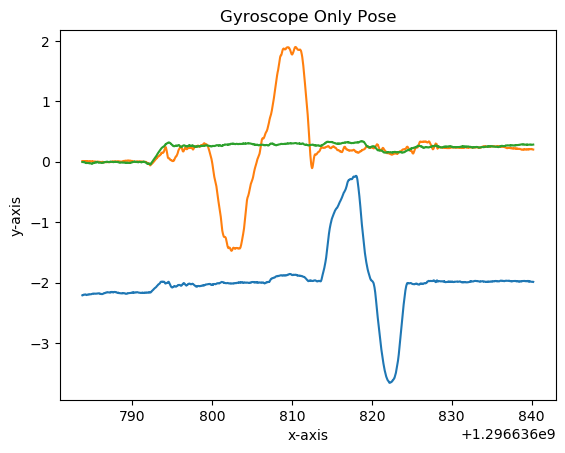

Bias -> x:-54794.92127581325 | y:-53538.06682901887 | z:67231.79175887944


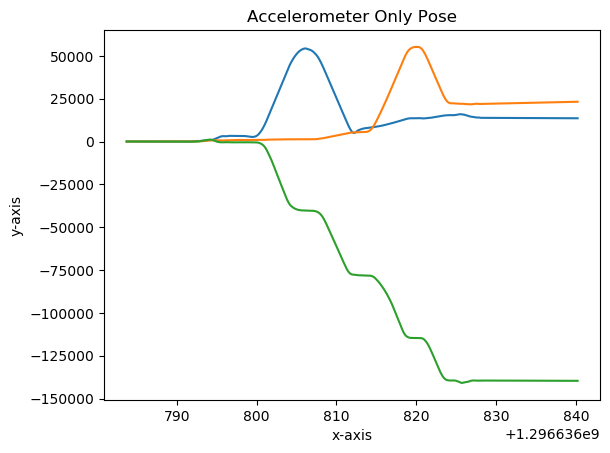

In [63]:
set1 = calculatePose(
    "Phase1/Data/Train/Vicon/viconRot1.mat",
    "Phase1/Data/Train/IMU/imuRaw1.mat",
    "Phase1/IMUParams.mat",
)

# set2 = calculatePose(
#     "Phase1/Data/Train/Vicon/viconRot2.mat",
#     "Phase1/Data/Train/IMU/imuRaw2.mat",
#     "Phase1/IMUParams.mat",
# )

# set3 = calculatePose(
#     "Phase1/Data/Train/Vicon/viconRot3.mat",
#     "Phase1/Data/Train/IMU/imuRaw3.mat",
#     "Phase1/IMUParams.mat",
# )

# set4 = calculatePose(
#     "Phase1/Data/Train/Vicon/viconRot4.mat",
#     "Phase1/Data/Train/IMU/imuRaw4.mat",
#     "Phase1/IMUParams.mat",
# )

# set5 = calculatePose(
#     "Phase1/Data/Train/Vicon/viconRot5.mat",
#     "Phase1/Data/Train/IMU/imuRaw5.mat",
#     "Phase1/IMUParams.mat",
# )

# set6 = calculatePose(
#     "Phase1/Data/Train/Vicon/viconRot6.mat",
#     "Phase1/Data/Train/IMU/imuRaw6.mat",
#     "Phase1/IMUParams.mat",
# )